# Aggregating Velocity and Acceleration Data
Aggregating Velocity and Acceleration Data from a Collection of Drive

In [9]:
import strym
from strym import strymread
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

## We are only going to collect Toyota RAV4 drives with Sprinkle driving the UA car. Thus we will ignore all Honda Pilot drives, and all VU Toyota drives

In [17]:
parentfolder = "../../PandaData/"
# dbcfile = '../examples/newToyotacode.dbc'
csvlist = []
folderlist = glob.glob(parentfolder+"*")
from dateutil import parser
from datetime import datetime
last_date = parser.parse("Sep 17 2020 12:00AM")

speedlist = []
for datafolder in folderlist:
    csvlisttmp = glob.glob(datafolder+"/*.csv")
    for f in csvlisttmp:
        # csvdate
        csvdate=last_date
        try:
            csvdate = datetime.strptime(f[len(parentfolder):len(parentfolder)+10],'%Y_%m_%d')
        except:
            csvdate = last_date
        if csvdate >= last_date:
            continue
        # we are looking ONLY for Jonathan's driving
        if "CAN" not in f:
            continue
        # skip the VU car
        if "2T3MWRFVXLW056972" in f:
            continue
        if "5FNYF6H05HB089022" in f:
            continue
        csvlist.append(f)

In [19]:
speed_list = []
steer_list = []
for csv in csvlist:
    print("\nReading the CSV file {}".format(csv))
    try:
        r = strymread(csvfile=csv)
        
        if r.success is True:
            if r.burst is True:
                print("Burst Data. Skipping ....")
                continue

            speed = r.speed()
            if speed.shape[0] == 0:
                continue
            steer = r.steer_angle()
            if steer.shape[0] == 0:
                continue

            speed_list.append(speed)
            steer_list.append(steer)
    except:
        print('Something is wrong w file...aborting')


Reading the CSV file ../../PandaData/2020_09_11/2020-09-11-18-42-57_2T3Y1RFV8KC014025_CAN_Messages.csv

Reading the CSV file ../../PandaData/2020_05_24/2020-05-24-15-51-32_2T3Y1RFV8KC014025_CAN_Messages.csv

Reading the CSV file ../../PandaData/2020_05_24/2020-05-24-15-34-52_2T3Y1RFV8KC014025_CAN_Messages.csv

Reading the CSV file ../../PandaData/2020_05_12/2020-05-12-15-23-19_2T3Y1RFV8KC014025_CAN_Messages.csv

Reading the CSV file ../../PandaData/2020_05_12/2020-05-12-14-32-13_2T3Y1RFV8KC014025_CAN_Messages.csv

Reading the CSV file ../../PandaData/2020_05_12/2020-05-12-14-04-29_2T3Y1RFV8KC014025_CAN_Messages.csv

Reading the CSV file ../../PandaData/2020_05_12/2020-05-12-13-25-00_2T3Y1RFV8KC014025_CAN_Messages.csv

Reading the CSV file ../../PandaData/2020_05_12/2020-05-12-16-39-03_2T3Y1RFV8KC014025_CAN_Messages.csv

Reading the CSV file ../../PandaData/2020_05_12/2020-05-12-16-33-50_2T3Y1RFV8KC014025_CAN_Messages.csv

Reading the CSV file ../../PandaData/2019_10_25/2019-10-25-13-5

## Save the variable

In [21]:
import pickle
datapath = '../../pickles/'
speedfile = 'all_speed.pickle'
steerfile = 'all_steer.pickle'

with open(datapath+speedfile, 'wb') as f:
    pickle.dump([speed_list], f)
    
with open(datapath+steerfile, 'wb') as f:
    pickle.dump([steer_list], f)

## Load the dataset

In [24]:
import pickle

datapath = '../../pickles/'
speedfile = 'all_speed.pickle'
steerfile = 'all_steer.pickle'

speed_list = None
steer_list = None
with open(datapath+speedfile, 'rb') as f:
    ss = pickle.load(f)
    speed_list = ss[0]
with open(datapath+steerfile, 'rb') as f:
    ss = pickle.load(f)
    steer_list = ss[0]

In [25]:
indices_t = []
new_speed_list = []
for i, s in enumerate(speed_list):
    if s.shape[0] > 10:
        new_speed_list.append(s)

Let's put it all together now by going through each list, and making them match on the same timescale as we have steering data

In [49]:
speed_steering_list =[]
for i, s in enumerate(speed_list):
    if s.shape[0] > 10:
        # let's line up velocity with steering angle for a scatter plot
        steering_new, speed_new  = strymread.ts_sync(steer_list[i], speed_list[i], rate=10, method ="nearest")
        speed_steering = pd.DataFrame()
        speed_steering['Time'] = speed_new['Time']
        speed_steering['Speed'] = speed_new['Message']
        speed_steering['Steering'] = abs(steering_new['Message'])
        speed_steering_list.append(speed_steering)

In [50]:
speed_steering_list[0]

,Time,Speed,Steering
Clock,,,
2020-09-12 01:42:58.799006939,1.599875e+09,0.0,114.0
2020-09-12 01:42:58.899024487,1.599875e+09,0.0,114.0
2020-09-12 01:42:58.999042273,1.599875e+09,0.0,114.0
2020-09-12 01:42:59.099059820,1.599875e+09,0.0,114.0
2020-09-12 01:42:59.199077368,1.599875e+09,0.0,114.0
...,...,...,...
2020-09-12 01:59:54.778089523,1.599876e+09,0.0,1.5
2020-09-12 01:59:54.878107071,1.599876e+09,0.0,1.5
2020-09-12 01:59:54.978124619,1.599876e+09,0.0,1.5


Now we plot all these speed/steering datasets

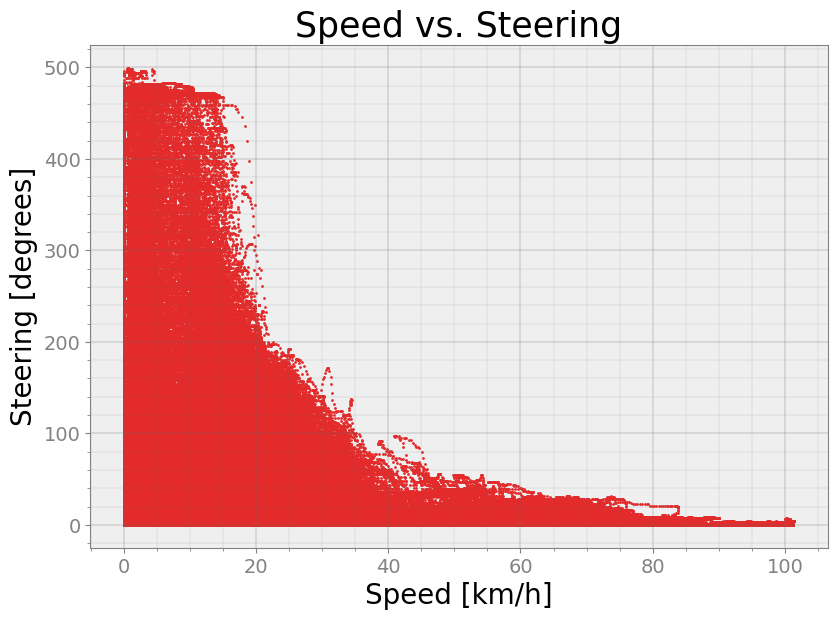

In [51]:
fig, ax = strymread.create_fig(1)
fig.set_size_inches(8, 6)
for speed_steering in speed_steering_list:
    ax[0].scatter(x = 'Speed', y = 'Steering', data = speed_steering, s = 1, color = "#E32b2b")
    ax[0].set_xlabel('Speed [km/h]')
    ax[0].set_ylabel('Steering [degrees]')
    ax[0].set_title('Speed vs. Steering')
plt.show()

In [95]:
new_speed_list[34]

,Time,Message
Clock,,
2020-03-26 17:03:11.229470015,1.585242e+09,16.827791
2020-03-26 17:03:11.230471134,1.585242e+09,16.827791
2020-03-26 17:03:11.232092857,1.585242e+09,16.844458
2020-03-26 17:03:11.234658957,1.585242e+09,16.844458
2020-03-26 17:03:11.235782146,1.585242e+09,16.827791
...,...,...
2020-03-26 17:38:03.747910976,1.585244e+09,0.000000
2020-03-26 17:38:03.768285990,1.585244e+09,0.000000
2020-03-26 17:38:03.787950039,1.585244e+09,0.000000


In [96]:
speed = pd.concat(new_speed_list)

In [97]:
accel = pd.concat(diffspeed)

In [98]:
speed.shape

(5546112, 2)

In [99]:
speed.sort_index(inplace=True)

# find the time values that are same and drop the latter entry. It is essential for spline
# interpolation to work 
collect_indices = []
for i in range(0, len(speed['Time'].values)-1):
    if speed['Time'].values[i] == speed['Time'].values[i+1]:
        collect_indices.append(speed.index.values[i+1])
speed = speed.drop(collect_indices)

In [100]:
speed.shape

(4991528, 2)

In [101]:
accel.shape

(4993940, 2)

In [102]:
accel.sort_index(inplace=True)

# find the time values that are same and drop the latter entry. It is essential for spline
# interpolation to work 
collect_indices = []
for i in range(0, len(accel['Time'].values)-1):
    if accel['Time'].values[i] == accel['Time'].values[i+1]:
        collect_indices.append(accel.index.values[i+1])
accel = accel.drop(collect_indices)

In [103]:
accel.shape

(4991528, 2)

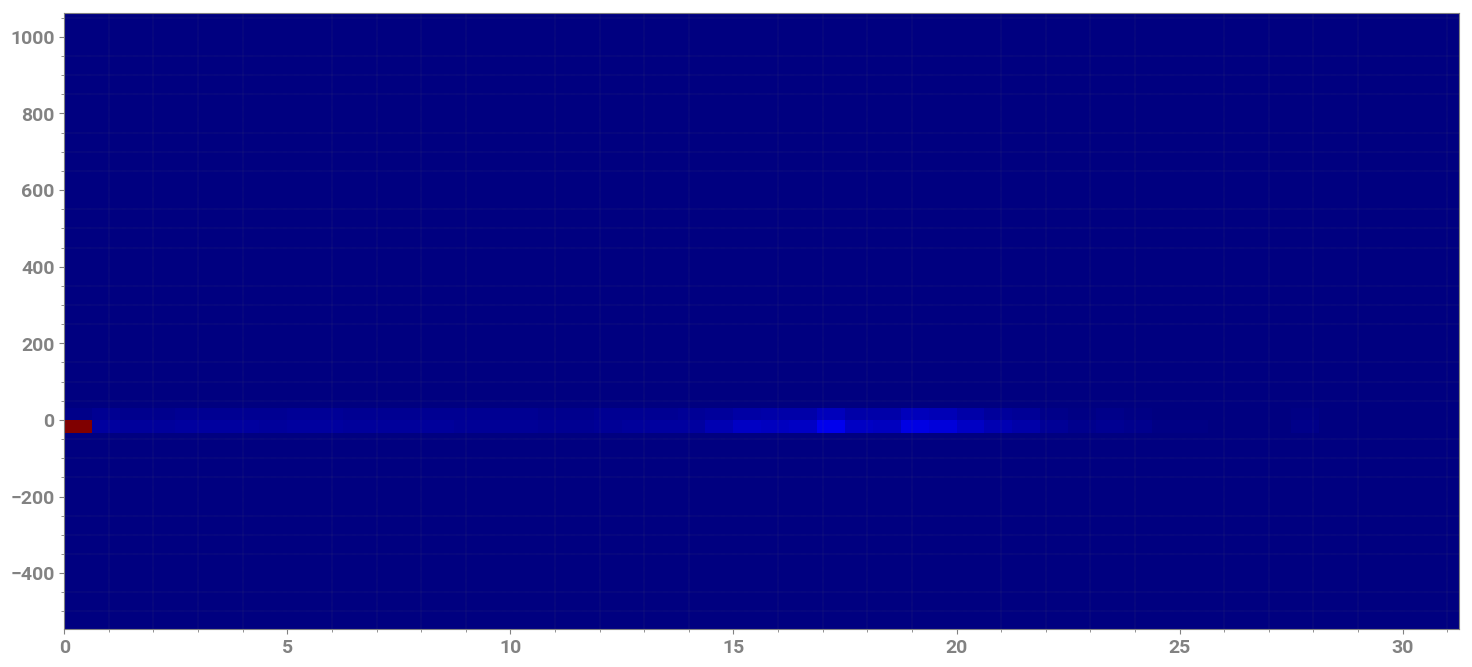

In [104]:
fig, ax = strymread.create_fig(1)
ax[0].hist2d(speed['Message'], accel['Message'], bins=(50, 50), cmap=plt.cm.jet)
plt.show()

In [105]:
newdf = pd.DataFrame()
newdf['Time'] = speed['Time']
newdf['Speed'] = speed['Message']
newdf['Accel'] = accel['Message']

In [106]:
newdf = newdf[(newdf['Accel'] > -10) & (newdf['Accel'] < 10)]

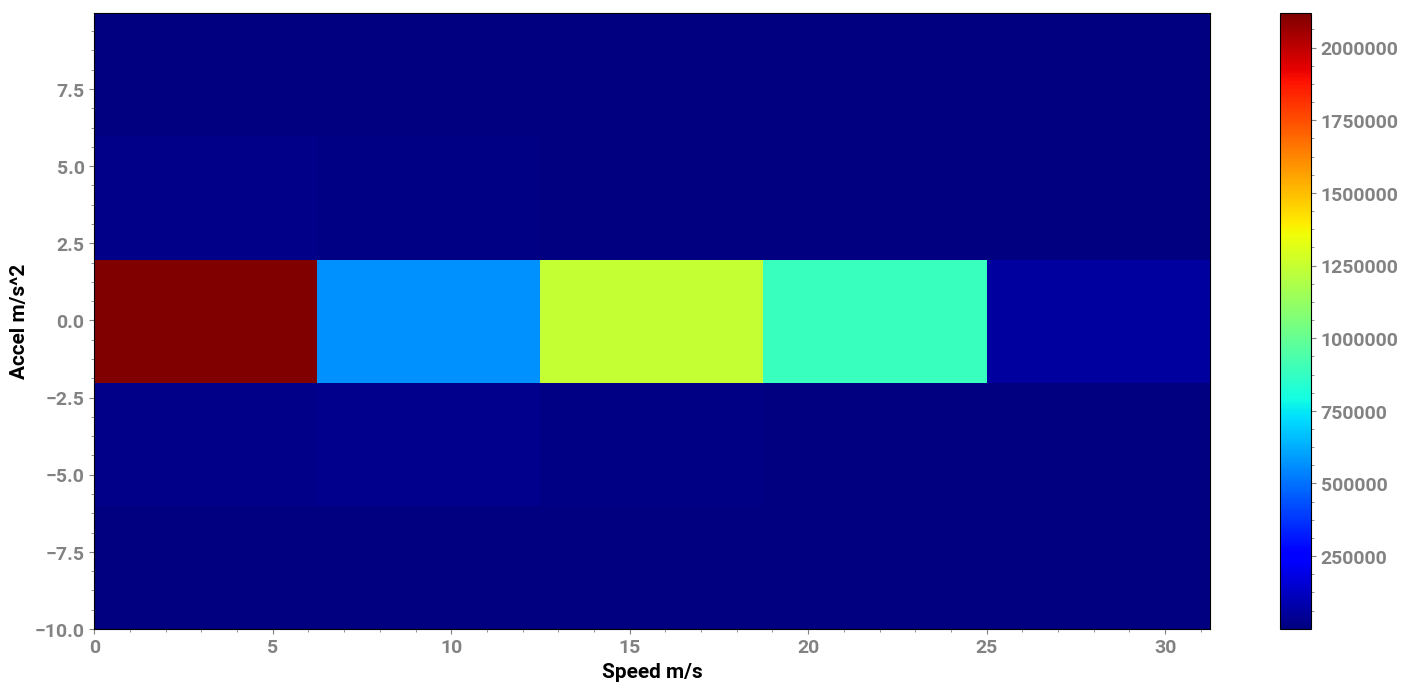

In [107]:
plt.hist2d(newdf['Speed'], newdf['Accel'], bins=(5, 5), cmap=plt.cm.jet)
plt.xlabel('Speed m/s')
plt.ylabel('Accel m/s^2')
plt.colorbar()
plt.show()

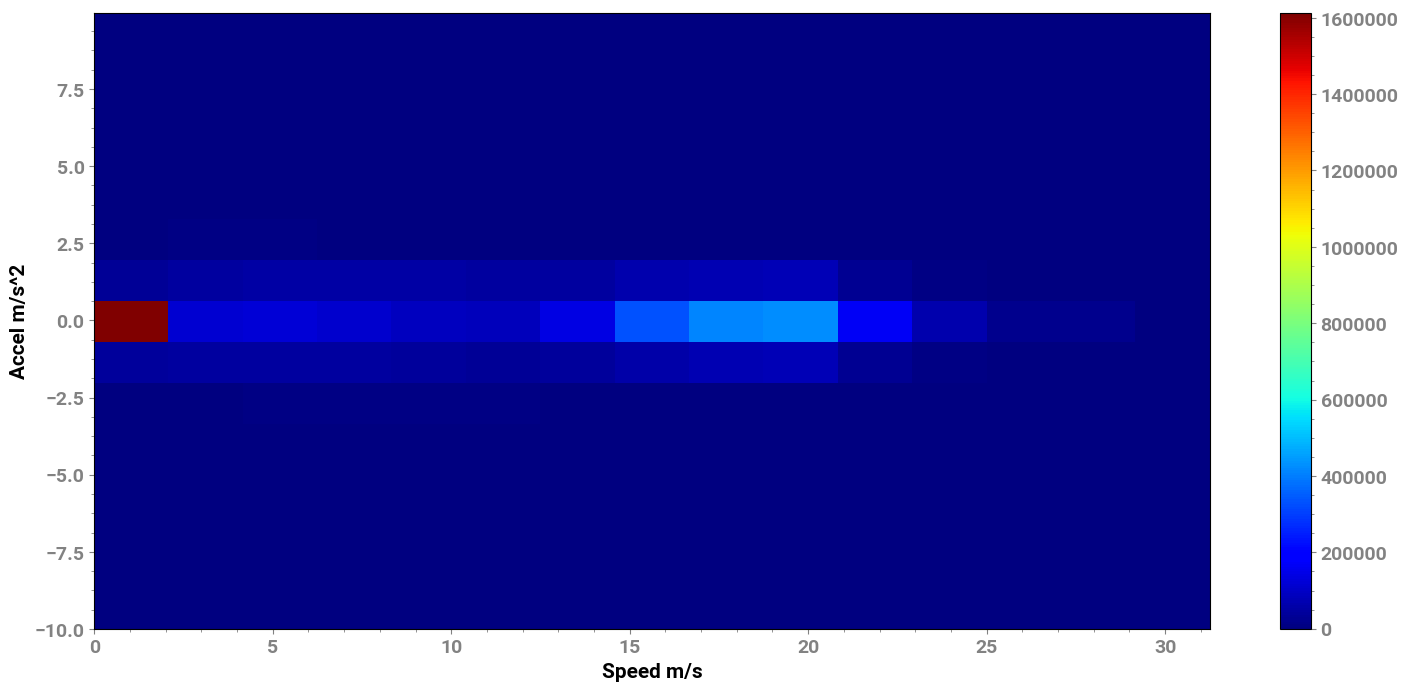

In [109]:
plt.hist2d(newdf['Speed'], newdf['Accel'], bins=(15, 15), cmap=plt.cm.jet)
plt.xlabel('Speed m/s')
plt.ylabel('Accel m/s^2')
plt.colorbar()
plt.show()

In [110]:
speed.shape

(4991528, 2)

In [114]:
variable_dict = {"speed": speed.to_numpy()}
import scipy.io as sio
matfile = '../../speed/all_speed.mat'
sio.savemat(matfile, variable_dict)

In [162]:
R = np.zeros(0)
for v in speed_list:
    w  = v.Time[-1] - v.Time[0]
    R = np.append(R, w)

Text(0, 0.5, 'Time (seconds)')

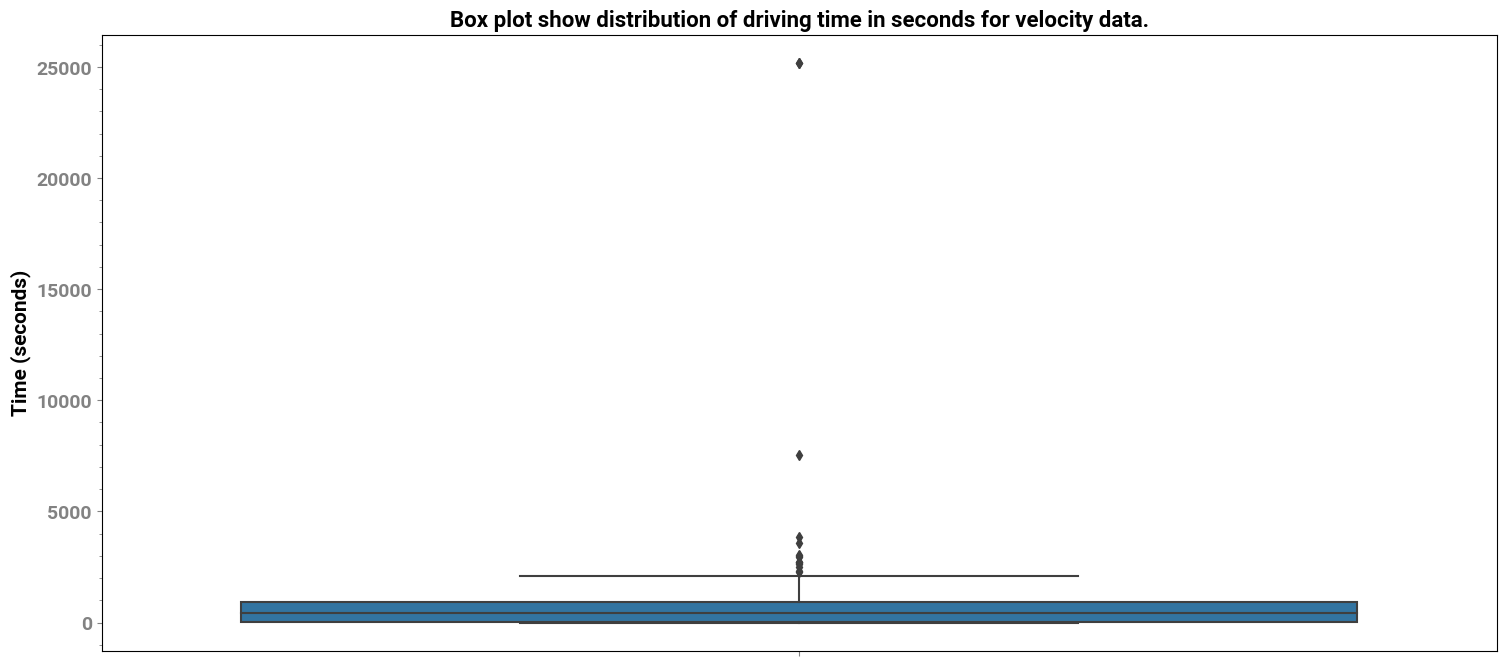

In [158]:
import seaborn as sea
sea.boxplot(R, orient="v")
plt.title('Box plot show distribution of driving time in seconds for velocity data.')
plt.ylabel('Time (seconds)')

In [161]:
np.sum(R)

177669.2773733139

In [168]:
R = np.zeros(0)
variable_dict_separate = {}
for i, v in enumerate(speed_list):
    variable_dict_separate['speed_'+str(i)] = v.to_numpy()
    

In [169]:
matfile = '../../speed/all_speed_separate.mat'
sio.savemat(matfile, variable_dict_separate)